# Understanding Attention and Multi-Head Attention

## 1. What is Attention?

**Attention** helps a model focus on the most relevant parts of the input when making predictions.

Imagine we have 3 sensor readings:


In [3]:
import torch

# Each row is a 2D feature vector at a time step
X = torch.tensor([
    [1.0, 0.0],  # sensor1
    [0.0, 1.0],  # sensor2
    [1.0, 1.0],  # sensor3
])


We want to compute **attention**: a new representation of each input as a weighted sum of all others, based on similarity.

### Scaled Dot-Product Attention Formula:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Where:
- \( Q \): Query
- \( K \): Key
- \( V \): Value
- \( d_k \): Dimension of key

We'll use identity projections for simplicity.


In [5]:
import torch.nn.functional as F

W_q = torch.eye(2)
W_k = torch.eye(2)
W_v = torch.eye(2)

Q = X @ W_q.T
K = X @ W_k.T
V = X @ W_v.T

# Scaled dot-product attention
scores = Q @ K.T
scaled_scores = scores / (2 ** 0.5)
attn_weights = F.softmax(scaled_scores, dim=-1)
attention_output = attn_weights @ V

print("Attention Output:\n", attention_output)


Attention Output:
 tensor([[0.8022, 0.5989],
        [0.5989, 0.8022],
        [0.7517, 0.7517]])


---

## 2. Why Multi-Head Attention?

Single attention might miss relationships. **Multi-head attention** applies attention multiple times in parallel with different learned projections.

Each head can focus on different patterns.

### Multi-Head Attention Steps:
1. Apply different linear projections to get Q, K, V for each head
2. Compute attention separately for each head
3. Concatenate outputs from all heads
4. Project the result with one final layer


In [6]:
# Head 1: normal identity projections
W_q1 = torch.tensor([[1., 0.], [0., 1.]])
W_k1 = torch.tensor([[1., 0.], [0., 1.]])
W_v1 = torch.tensor([[1., 0.], [0., 1.]])

# Head 2: swapped projections (simulating different view)
W_q2 = torch.tensor([[0., 1.], [1., 0.]])
W_k2 = torch.tensor([[0., 1.], [1., 0.]])
W_v2 = torch.tensor([[0., 1.], [1., 0.]])

# Head 1 attention
Q1 = X @ W_q1.T
K1 = X @ W_k1.T
V1 = X @ W_v1.T
scores1 = Q1 @ K1.T / (2 ** 0.5)
attn1 = F.softmax(scores1, dim=-1)
out1 = attn1 @ V1

# Head 2 attention
Q2 = X @ W_q2.T
K2 = X @ W_k2.T
V2 = X @ W_v2.T
scores2 = Q2 @ K2.T / (2 ** 0.5)
attn2 = F.softmax(scores2, dim=-1)
out2 = attn2 @ V2

# Concatenate heads
multi_head_output = torch.cat([out1, out2], dim=-1)
print("Multi-Head Attention Output:\n", multi_head_output)


Multi-Head Attention Output:
 tensor([[0.8022, 0.5989, 0.5989, 0.8022],
        [0.5989, 0.8022, 0.8022, 0.5989],
        [0.7517, 0.7517, 0.7517, 0.7517]])


---

## 3. Learnable Multi-Head Attention 

In practice, we use `nn.Linear` to learn weights. Here's a simple multi-head attention implementation.


In [8]:
import torch.nn as nn


class SimpleMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        # The embedding dimension must be divisible by the number of attention heads,
        # since each head processes a chunk of size embed_dim // num_heads.
        assert embed_dim%num_heads == 0
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

    def forward(self, X):
        B, T, D = x.size()
        # B - batch size
        # T Sequence length(Time Steps) : T=3 if we have 3 sensor reading
        # D - Dimentionality of each input vector : D=4 for 4 features
        # H - Number of attention heads: H=2
        # D/H - Head dimension: Each head gets a chunk of the full embedding. 
        #                       Ex: If D=4, H=2, then each head gets 4/2=2 features.
        Q = self.W_q(x)  # (B, T, D)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape to (B, H, T, D/H)
        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention
        scores = Q @ K.transpose(-2, -1) / self.head_dim ** 0.5
        attn_weights = F.softmax(scores, dim=-1)
        out = attn_weights @ V  # (B, H, T, D/H)

        # Concatenate heads
        out = out.transpose(1, 2).contiguous().view(B, T, self.embed_dim)
        return self.W_o(out)



In [9]:
# Example input
torch.manual_seed(42)
x = torch.rand(1, 3, 4)  # (batch, sequence length, embedding dim)

# Create multi-head attention layer
mha = SimpleMultiHeadAttention(embed_dim=4, num_heads=2)
out = mha(x)

print("Learnable Multi-Head Attention Output:\n", out)


Learnable Multi-Head Attention Output:
 tensor([[[-0.3734,  0.2497,  0.2440, -0.1409],
         [-0.3829,  0.2564,  0.2437, -0.1439],
         [-0.3764,  0.2518,  0.2439, -0.1417]]], grad_fn=<ViewBackward0>)


---

## Summary

| Concept              | Purpose                                     |
|----------------------|---------------------------------------------|
| Attention            | Weighted focus on input based on similarity |
| Scaled Dot Product   | Measure similarity between query and key    |
| Multi-Head Attention | Multiple views of attention in parallel     |
| `nn.Linear`          | Learns weights for Q, K, V projections      |

---




## Real-World Use Case: Predict Driver Behavior from Sensor Data

Imagine you are building a system to monitor and classify driver behavior using sensor data collected from the vehicle and the driver (e.g., brake pressure, speed, blink rate, head tilt, etc.).

Each time step contains an 8-dimensional vector of readings.

We want to use **multi-head attention** to:
- Learn which **sensor dimensions** are important (feature-level attention)
- Learn which **time steps** are relevant (temporal attention)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Sample input: B = 2 drivers, T = 50 time steps, D = 8 sensor features
B, T, D = 2, 50, 8
x = torch.rand(B, T, D)  # Simulated sensor data


### Attention Model for Driver Behavior

We'll use a **multi-head attention mechanism** where each head focuses on different aspects of the input sequence (e.g., speed dynamics, eye movement, braking pattern).


In [12]:
class DriverAttentionModel(nn.Module):
    def __init__(self, embed_dim=8, num_heads=4, num_classes=4):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dim must be divisible by number of heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers for Q, K, V projections
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)  # e.g., Normal, Sharp Turn, Braking, Drowsy
        )

    def forward(self, x):
        B, T, D = x.size()

        # Project to Q, K, V
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape to (B, H, T, D/H)
        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled Dot-Product Attention
        scores = Q @ K.transpose(-2, -1) / self.head_dim ** 0.5
        attn = F.softmax(scores, dim=-1)
        out = attn @ V

        # Merge heads back
        out = out.transpose(1, 2).contiguous().view(B, T, self.embed_dim)

        # Pool over time (mean-pooling)
        pooled = out.mean(dim=1)  # (B, D)

        # Classify
        return self.classifier(pooled)


### Run the model on sensor data


In [13]:
# Create model and run inference
model = DriverAttentionModel(embed_dim=8, num_heads=4, num_classes=4)
output = model(x)

# Convert output to probabilities
probabilities = F.softmax(output, dim=-1)
print("Driver behavior probabilities:\n", probabilities)


Driver behavior probabilities:
 tensor([[0.2666, 0.2618, 0.2021, 0.2695],
        [0.2714, 0.2607, 0.1981, 0.2699]], grad_fn=<SoftmaxBackward0>)


## Prediction Meaning

Each row in the output corresponds to a driver. Each column gives the probability of:
1. Normal driving
2. Sharp Turn
3. Hard Braking
4. Drowsy Driving


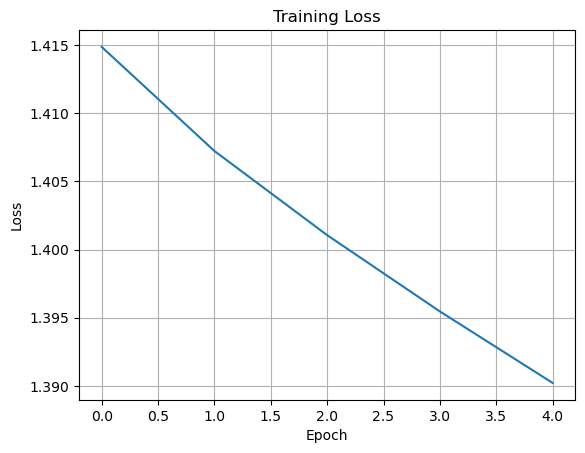

Test Accuracy: 12.50%
   Sample #  Predicted Class
0         1                2
1         2                2
2         3                2
3         4                2
4         5                2


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set random seed
torch.manual_seed(42)

# Dataset: 40 samples, 20 time steps, 8 sensor features
B, T, D = 40, 20, 8
num_classes = 4
num_heads = 2
embed_dim = D

# Create synthetic dataset
X = torch.rand(B, T, D)
y = torch.randint(0, num_classes, (B,))

# Split into train/test
split = int(0.8 * B)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

# Attention model definition
class DriverAttentionModel(nn.Module):
    def __init__(self, embed_dim=8, num_heads=2, num_classes=4):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        B, T, D = x.size()
        Q = self.W_q(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        out = attn @ V
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        pooled = out.mean(dim=1)
        return self.classifier(pooled)

# Instantiate model
model = DriverAttentionModel(embed_dim=D, num_heads=num_heads, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train
train_losses = []
for epoch in range(5):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

# Plot loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        preds = torch.argmax(pred, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")

# Predict on new unseen inputs
new_samples = torch.rand(5, T, D)
with torch.no_grad():
    new_preds = model(new_samples)
    predicted_classes = torch.argmax(new_preds, dim=1)

# Display predictions
df = pd.DataFrame({
    "Sample #": np.arange(1, 6),
    "Predicted Class": predicted_classes.numpy()
})
print(df)


In [15]:
class DriverAttentionModel(nn.Module):
    def __init__(self, embed_dim=8, num_heads=2, num_classes=4):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x, return_attention=False):
        B, T, D = x.size()
        Q = self.W_q(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)  # (B, H, T, T)
        out = attn @ V
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        pooled = out.mean(dim=1)
        logits = self.classifier(pooled)

        if return_attention:
            return logits, attn
        else:
            return logits


In [19]:
# Define input and model parameters
T = 20  # sequence length
D = 8   # embedding/sensor dimension
num_heads = 2
num_classes = 4

# Instantiate the model
model = DriverAttentionModel(embed_dim=D, num_heads=num_heads, num_classes=num_classes)


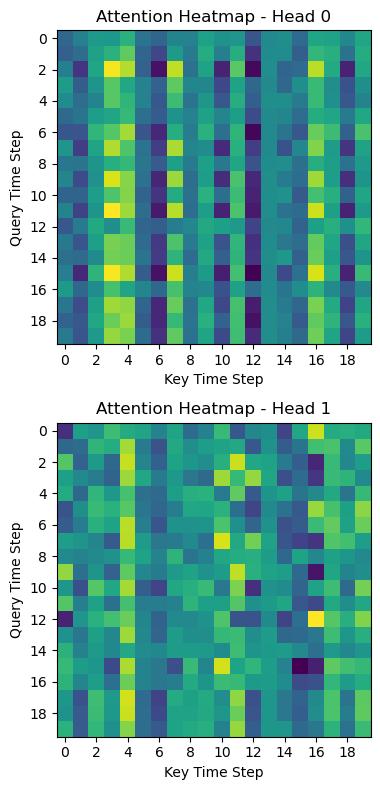

In [20]:
# Generate a single test input
test_sample = torch.rand(1, T, D)

# Forward pass with attention output
model.eval()
with torch.no_grad():
    logits, attn_weights = model(test_sample, return_attention=True)

# Extract attention for head 0 and head 1 (shape: [B, H, T, T])
attn = attn_weights[0]  # remove batch dimension → shape: [H, T, T]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(model.num_heads, 1, figsize=(8, 4 * model.num_heads))
for h in range(model.num_heads):
    axs[h].imshow(attn[h].cpu().numpy(), cmap='viridis')
    axs[h].set_title(f'Attention Heatmap - Head {h}')
    axs[h].set_xlabel('Key Time Step')
    axs[h].set_ylabel('Query Time Step')
    axs[h].set_xticks(range(0, T, 2))
    axs[h].set_yticks(range(0, T, 2))
    axs[h].grid(False)

plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import uuid
import numpy as np

n_rows = 10
df = pd.DataFrame({
    'unique_id': ["Test"]*10,
    'random_num1': np.random.rand(n_rows),
    'random_num2': np.random.randint(1, 100, n_rows)
})

print(df)

  unique_id  random_num1  random_num2
0      Test     0.654427            7
1      Test     0.956979           97
2      Test     0.050755           60
3      Test     0.220847           79
4      Test     0.516391           95
5      Test     0.429480           53
6      Test     0.777281            1
7      Test     0.199003           44
8      Test     0.237870           33
9      Test     0.054099           99


In [26]:
print(type(df.values))
n = df.values
n

<class 'numpy.ndarray'>


array([['Test', 0.6544272035752784, 7],
       ['Test', 0.9569789277156429, 97],
       ['Test', 0.05075480268577737, 60],
       ['Test', 0.2208467428390366, 79],
       ['Test', 0.5163910981401336, 95],
       ['Test', 0.42948035800095985, 53],
       ['Test', 0.7772813794191421, 1],
       ['Test', 0.19900318111926152, 44],
       ['Test', 0.23786955763630813, 33],
       ['Test', 0.05409928368137895, 99]], dtype=object)

In [36]:
s = 5
l = len(n)
p = n[l-s:]
q = n[:l-5]

In [37]:
q

array([['Test', 0.6544272035752784, 7],
       ['Test', 0.9569789277156429, 97],
       ['Test', 0.05075480268577737, 60],
       ['Test', 0.2208467428390366, 79],
       ['Test', 0.5163910981401336, 95]], dtype=object)

In [38]:
np.concatenate((p,q), axis=1)

array([['Test', 0.42948035800095985, 53, 'Test', 0.6544272035752784, 7],
       ['Test', 0.7772813794191421, 1, 'Test', 0.9569789277156429, 97],
       ['Test', 0.19900318111926152, 44, 'Test', 0.05075480268577737, 60],
       ['Test', 0.23786955763630813, 33, 'Test', 0.2208467428390366, 79],
       ['Test', 0.05409928368137895, 99, 'Test', 0.5163910981401336, 95]],
      dtype=object)